<img src="https://img.freepik.com/premium-photo/elderly-man-carefully-holding-detailed-brain-model_157125-20677.jpg" width=70%/>


**Alzheimer's disease** is a condition where neurons within the brain stop functioning, lose connection with other neurons and die. It's the most common cause of dementia, a loss of brain function that can adversely impact memory, thinking, language, judgment and behavior. Alzheimer's is irreversible and progressive.

Alzheimer's is evaluated by identifying certain symptoms and ruling out other possible causes of dementia. Your doctor will likely perform a complete medical exam, including neurological, blood and brain imaging exams, such as CT, MRI or PET/CT of the head. There is no cure for Alzheimer's disease. However, your doctor may prescribe medication to slow the disease's progression and manage your symptoms.

**MRI of the head**: Magnetic resonance imaging (MRI) uses a powerful magnetic field, radio frequency pulses and a computer to produce detailed pictures of organs, soft tissues, bone and virtually all other internal body structures. MRI can detect brain abnormalities associated with mild cognitive impairment (MCI) and can be used to predict which patients with MCI may eventually develop Alzheimer's disease. In the early stages of Alzheimer's disease, an MRI scan of the brain may be normal. In later stages, MRI may show a decrease in the size of different areas of the brain (mainly affecting the temporal and parietal lobes).

## In this NoteBook

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet50** architecture, to detect **"Mild Demented"**, **"Moderate Demented"**, **"Non Demented"** and **"Very Mild Demented"** in patient's MRI.

# 1. Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 2. Uploading the Data

In [ ]:
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = '/content/drive/myDrive/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# 3. Defining Categories

In [ ]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

# 4. Creating Train and Validation DataFrame

In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape
# fie path / categoryID / catLable

(33984, 3)

In [ ]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=4)

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [ ]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(27187, 3)
(6797, 3)


In [ ]:
train.head()

,file,category,category_id
0,train/ModerateDemented/636f0d66-9951-4923-98e8...,ModerateDemented,1
1,train/ModerateDemented/2fe78b75-d0dd-4e2f-986c...,ModerateDemented,1
2,train/VeryMildDemented/ad7627bc-106b-49b2-9a86...,VeryMildDemented,3
3,train/VeryMildDemented/c46be387-24c3-4ff1-b875...,VeryMildDemented,3
4,train/MildDemented/9313b3a2-789e-46f4-b29a-cca...,MildDemented,0


In [ ]:
validation.head()

,file,category,category_id
0,train/MildDemented/12a0f22a-33e7-4500-9700-a4b...,MildDemented,0
1,train/NonDemented/2d55504a-0c14-40a9-bebc-8263...,NonDemented,2
2,train/MildDemented/11796101-cdc3-44ba-b4cb-d57...,MildDemented,0
3,train/MildDemented/8c945091-1924-46ef-9fd3-b16...,MildDemented,0
4,train/VeryMildDemented/04e832cb-445d-44ae-913b...,VeryMildDemented,3


# 5. Creating Test DataFrame

In [ ]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(6400, 3)

# 6. Demonstrating Example Images

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

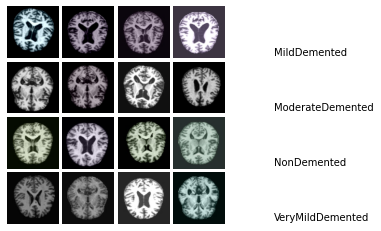

In [ ]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1

plt.show();

# 7. Keras ImageDataGenerator

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="/content/drive/myDrive/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="/content/drive/myDrive/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="/content/drive/myDrive/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.
